In this Notebook we want to show that our model is capable of 'predicting the future' by ...
1. Calibrating up to a particular point in the past.
2. Defining a number of possible scenarios, based on variations in social contact, vaccination strategy, rise of VOCs, ...
3. Simulating the future in these three possible scenarios
4. Comparing the outcome of these scenarios with real-life scenario

Ideally, the prediction and the real-life outcome should overlap. This overlap will not be perfect, so this requires a discussion.

Try to _keep it simple_ for the paper. For actual detailed predictions, refer to the progress reports (published on Research Gate)

The first couple of paragraphs here are roughly copied from `models/utils.py`'s `initialize_COVID19_SEIQRD_spatial_rescaling` function

We define three future approaches where we alter social contact

# Load Python packages

In [1]:
from platform import python_version
print(python_version())

3.7.13


In [2]:
import numpy as np
import os
import pickle
import pandas as pd
import json
import random
import matplotlib.pyplot as plt

# Import the file with the model definitions
from covid19model.models.models import COVID19_SEIQRD_spatial_rescaling
from covid19model.models.utils import initialize_COVID19_SEIQRD_spatial_rescaling
# Import time-dependent parameter functions for resp. P, Nc, alpha, N_vacc, season_factor
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function, \
                                                      make_contact_matrix_function, \
                                                      make_VOC_function, \
                                                      make_vaccination_rescaling_function, \
                                                      make_seasonality_function
# Import packages containing functions to load in data used in the model and the time-dependent parameter functions
from covid19model.data import mobility, sciensano, model_parameters
from covid19model.data.utils import convert_age_stratified_quantity
from covid19model.optimization.utils import samples_dict_to_emcee_chain

from covid19model.visualization.output import color_timeframes

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Spatial stratification
agg = 'prov'

 # Load necessary data

In [3]:
# Population size, interaction matrices and the model parameters
initN, Nc_dict, params, CORE_samples_dict = model_parameters.get_COVID19_SEIQRD_parameters(spatial='prov')

# Google Mobility data (for social contact Nc)
df_google = mobility.get_google_mobility_data(update=False, provincial=True)

# Load and format mobility dataframe (for mobility place)
proximus_mobility_data = mobility.get_proximus_mobility_data(agg)

# Variants of concern
# VOCs = ['WT', 'abc']
VOCs = ['WT', 'abc', 'delta']
VOC_logistic_growth_parameters, VOC_params = model_parameters.get_COVID19_SEIQRD_VOC_parameters(VOCs=VOCs)
params.update(VOC_params)

# Load and format local vaccination-induced rescaling data, which is also under the sciensano object
# rescaling_df = sciensano.get_vaccination_rescaling_values(spatial=True)


# Remove superfluous parameters from default params dict
superfluous_params = ['f_immune_escape', 'e_s', 'e_h', 'e_i', 'doses', 'd_vacc', 'N_vacc', 'daily_doses', 'delay_immunity', 'vacc_order', 'stop_idx', 'refusal', 'initN', 'default_mobility', 'onset_days']
# superfluous_params += ['amplitude', 'peak_shift']
for key in superfluous_params:
    if key in params:
        params.pop(key)

# Add new parameters (these will be time-dependent soon)
params['E_susc'] = np.ones([11, 10])
params['E_inf'] = np.ones([11, 10])
params['E_hosp'] = np.ones([11, 10])

# Add seasonality parameter
params['seasonality'] = 1

# Load time-dependent parameter functions

In [4]:
# Time-dependent social contact matrix over all policies, updating Nc
# policies used in best-fit
policy_function_actual = make_contact_matrix_function(df_google, Nc_dict).policies_all_spatial
policy_function_work_actual = make_contact_matrix_function(df_google, Nc_dict).policies_all_work_only
# policies used in various scenarios
policy_function = make_contact_matrix_function(df_google, Nc_dict).policies_all_spatial_scenarios
policy_function_work = make_contact_matrix_function(df_google, Nc_dict).policies_all_work_only_scenarios

# Time-dependent mobility function, updating P (place)
mobility_function = \
    make_mobility_update_function(proximus_mobility_data).mobility_wrapper_func

# Time-dependent VOC function, updating alpha
VOC_function = make_VOC_function(VOC_logistic_growth_parameters['logistic_growth'])

# Time-dependent vaccination-induced rescaling parameter functions, updating E_susc^g, E_inf^g, E_hosp^g
E_susc_function = make_vaccination_rescaling_function(agg=agg).E_susc
E_inf_function = make_vaccination_rescaling_function(agg=agg).E_inf
E_hosp_function = make_vaccination_rescaling_function(agg=agg).E_hosp

# Time-dependent seasonality function, updating season_factor
seasonality_function = make_seasonality_function()

# Define initial conditions

In [5]:
# Get correct initial condition
start_date = '2020-03-17'
age_classes = pd.IntervalIndex.from_tuples([(0,12),(12,18),(18,25),(25,35),(35,45),(45,55),(55,65),(65,75),(75,85),(85,120)], closed='left')

samples_path = '../../data/interim/model_parameters/COVID19_SEIQRD/initial_conditions/'+agg+'/'

with open(samples_path+'initial_states-COVID19_SEIQRD_spatial.pickle', 'rb') as handle:
    load = pickle.load(handle)
    initial_states = load[start_date]
    
for key,value in initial_states.items():
    converted_value = np.zeros([value.shape[0], len(age_classes)])
    for i in range(value.shape[0]):
        column = value[i,:]
        data = pd.Series(index=age_classes, data=column)
        converted_value[i,:] = convert_age_stratified_quantity(data, age_classes).values
    initial_states.update({key: converted_value})

# Initialise models
Using the particular types of "future" time-dependent parameter functions

In [6]:
params['Nc_home'] = Nc_dict['home']
params['nc'] = np.ones(11)
params.pop('onset_immunity', None)
params.pop('waning', None)

# Initiate model with initial states, defined parameters, and proper time dependent functions

params['scenario'] = 'S0'    
model_S0 = COVID19_SEIQRD_spatial_rescaling(initial_states, params, spatial='prov', time_dependent_parameters={'Nc' : policy_function,
                                                                                                            'Nc_work' : policy_function_work,
                                                                                                            'place' : mobility_function,
                                                                                                            'f_VOC' : VOC_function,
                                                                                                            'E_susc' : E_susc_function,
                                                                                                            'E_inf' : E_inf_function,
                                                                                                            'E_hosp' : E_hosp_function,
                                                                                                            'seasonality' : seasonality_function})
params['scenario'] = 'S1'
model_S1 = COVID19_SEIQRD_spatial_rescaling(initial_states, params, spatial='prov', time_dependent_parameters={'Nc' : policy_function,
                                                                                                            'Nc_work' : policy_function_work,
                                                                                                            'place' : mobility_function,
                                                                                                            'f_VOC' : VOC_function,
                                                                                                            'E_susc' : E_susc_function,
                                                                                                            'E_inf' : E_inf_function,
                                                                                                            'E_hosp' : E_hosp_function,
                                                                                                            'seasonality' : seasonality_function})

params['scenario'] = 'S2'
model_S2 = COVID19_SEIQRD_spatial_rescaling(initial_states, params, spatial='prov', time_dependent_parameters={'Nc' : policy_function,
                                                                                                            'Nc_work' : policy_function_work,
                                                                                                            'place' : mobility_function,
                                                                                                            'f_VOC' : VOC_function,
                                                                                                            'E_susc' : E_susc_function,
                                                                                                            'E_inf' : E_inf_function,
                                                                                                            'E_hosp' : E_hosp_function,
                                                                                                            'seasonality' : seasonality_function})
    
params['scenario'] = 'S3'
model_S3 = COVID19_SEIQRD_spatial_rescaling(initial_states, params, spatial='prov', time_dependent_parameters={'Nc' : policy_function,
                                                                                                            'Nc_work' : policy_function_work,
                                                                                                            'place' : mobility_function,
                                                                                                            'f_VOC' : VOC_function,
                                                                                                            'E_susc' : E_susc_function,
                                                                                                            'E_inf' : E_inf_function,
                                                                                                            'E_hosp' : E_hosp_function,
                                                                                                            'seasonality' : seasonality_function})

    
# hard-code social intertia values
model_S0.parameters['l1'] = 21 # 21
model_S0.parameters['l2'] = 7
model_S1.parameters['l1'] = 21 # 21
model_S1.parameters['l2'] = 7
model_S2.parameters['l1'] = 21 # 21
model_S2.parameters['l2'] = 7
model_S3.parameters['l1'] = 21 # 21
model_S3.parameters['l2'] = 7

# hard-code increase in hospitalisation propensity
model_S0.parameters['K_hosp'] = np.array([1.62,1.62], np.float64)
model_S1.parameters['K_hosp'] = np.array([1.62,1.62], np.float64)
model_S2.parameters['K_hosp'] = np.array([1.62,1.62], np.float64)
model_S3.parameters['K_hosp'] = np.array([1.62,1.62], np.float64)

# Define parameter dictionary and draw function

In [7]:
# Identify sampels dict (output from calibration up to the desired point)
# json_name = 'prov_test_rescaling_SAMPLES_2022-03-11.json'
json_name = 'prov_BASE_SAMPLES_2022-04-21.json'
json_loc = f"../../data/interim/model_parameters/COVID19_SEIQRD/calibrations/{agg}"

# Load dict and thin/discard
samples_dict = json.load(open(f'{json_loc}/{json_name}'))
print("Keys in samples_dict: ", samples_dict.keys())
print("====================")
print("This calibration ends in", samples_dict['end_calibration'])

Keys in samples_dict:  dict_keys(['beta_R', 'beta_U', 'beta_M', 'eff_schools', 'eff_work', 'eff_rest', 'mentality', 'eff_home', 'K_inf_abc', 'K_inf_delta', 'amplitude', 'zeta', 'warmup', 'n_chains', 'start_calibration', 'end_calibration', 'dispersion'])
This calibration ends in 2021-10-07


In [8]:
# match the draw function with the available keys in the params dict
def draw_fcn(param_dict,samples_dict):
    # pick one random value from the dictionary
    idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
    # take out the other parameters that belong to the same iteration
    param_dict['beta_U'] = samples_dict['beta_U'][idx]
    param_dict['beta_M'] = samples_dict['beta_M'][idx]
    # param_dict['l1'] = samples_dict['l1'][idx] # hard-coded to 14
    # param_dict['l2'] = samples_dict['l2'][idx] # hard-coded to 14
    param_dict['eff_schools'] = samples_dict['eff_schools'][idx]
    param_dict['eff_work'] = samples_dict['eff_work'][idx]
    param_dict['eff_rest'] = samples_dict['eff_rest'][idx]
    param_dict['mentality'] = samples_dict['mentality'][idx]
    param_dict['eff_home'] = samples_dict['eff_home'][idx]
    # param_dict['K_inf'] = np.array([samples_dict['K_inf_abc'][idx], samples_dict['K_inf_delta'][idx]], np.float64)
    param_dict['K_inf'] = np.array([samples_dict['K_inf_abc'][idx], samples_dict['K_inf_abc'][idx]], np.float64)
    # param_dict['K_inf'] = np.array([samples_dict['K_inf_abc'][idx]], np.float64)
    param_dict['amplitude'] = samples_dict['amplitude'][idx]
    param_dict['zeta'] = samples_dict['zeta'][idx]
    return param_dict

# Make simulation

**Question**! Shouldn't we als thin out the param dict when we sample this making time series?

In [60]:
start_date = samples_dict['start_calibration']
end_date = pd.Timestamp(2021, 9, 1) # to be changed

warmup = int(samples_dict['warmup'])

# remove amplitude
# if 'amplitude' in samples_dict:
#     samples_dict.pop('amplitude')

N=100 # number of simulations with independent draws from the posterior of the sampled parameter values

print("Working on S0                    ")
out_S0 = model_S0.sim(end_date, start_date=start_date, warmup=warmup, N=N, \
                draw_fcn=draw_fcn, samples=samples_dict, verbose=True)
print("Working on S1                    ")
out_S1 = model_S1.sim(end_date, start_date=start_date, warmup=warmup, N=N, \
                draw_fcn=draw_fcn, samples=samples_dict, verbose=True)
print("Working on S2                    ")
out_S2 = model_S2.sim(end_date, start_date=start_date, warmup=warmup, N=N, \
                draw_fcn=draw_fcn, samples=samples_dict, verbose=True)
print("Working on S3                    ")
out_S3 = model_S3.sim(end_date, start_date=start_date, warmup=warmup, N=N, \
                draw_fcn=draw_fcn, samples=samples_dict, verbose=True)

Working on S0                    
Working on S1                    
Working on S2                    
Working on S3                    


# Make graphs

## Load Sciensano data

In [61]:
start_date = samples_dict['start_calibration']
end_date = pd.Timestamp(2021, 9, 1) # to be changed

from covid19model.data import sciensano
nonpublic_ts = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, values='hospitalised_IN', moving_avg=False)
all_dates = nonpublic_ts.sum(axis=1).index
plot_dates = all_dates[all_dates <= end_date]
plot_dates = plot_dates[plot_dates >= start_date]
plot_values = nonpublic_ts[start_date : end_date].sum(axis=1).values

## Plot model simulations and social contact behaviour

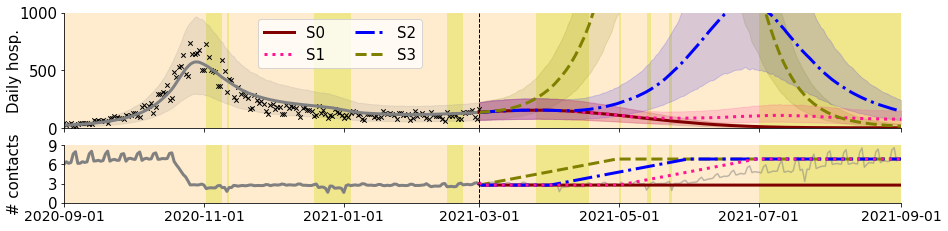

In [67]:
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(15,3.5), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
scenario_start = pd.Timestamp(2021, 3, 1)

# Background
week_color='blanchedalmond'#'white'
weekend_color='blanchedalmond'#'lightgrey'
vacation_color='khaki'#weekend_color
color_timeframes(start_date, end_date, ax=ax0, week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
color_timeframes(start_date, end_date, ax=ax1, week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

### Simulations
color_S0 = 'maroon'
color_S1 = 'olive'
color_S2 = 'blue'
color_S3 = 'deeppink'
linestyle_S0 = '-'
linestyle_S1 = '--'
linestyle_S2 = '-.'
linestyle_S3 = ':'

# out_S0['H_in'].sum(dim='place').sum(dim='Nc').plot.line(x='time', color=color_S0, alpha=2/N, ax=ax, linewidth=1)
# out_S1['H_in'].sum(dim='place').sum(dim='Nc').plot.line(x='time', color=color_S1, alpha=2/N, ax=ax, linewidth=1)
# out_S2['H_in'].sum(dim='place').sum(dim='Nc').plot.line(x='time', color=color_S2, alpha=2/N, ax=ax, linewidth=1)
# out_S3['H_in'].sum(dim='place').sum(dim='Nc').plot.line(x='time', color=color_S3, alpha=2/N, ax=ax, linewidth=1)

S0_values = out_S0['H_in'].sum(dim='place').sum(dim='Nc').values
S1_values = out_S1['H_in'].sum(dim='place').sum(dim='Nc').values
S2_values = out_S2['H_in'].sum(dim='place').sum(dim='Nc').values
S3_values = out_S3['H_in'].sum(dim='place').sum(dim='Nc').values

# Currently the Poisson errors are taken. This should be generalised to negative binomial error
dispersal = 1/0.20
S0_errors = np.sqrt(np.mean(S0_values,axis=0) + np.mean(S0_values,axis=0)**2/dispersal)
S1_errors = np.sqrt(np.mean(S1_values,axis=0) + np.mean(S1_values,axis=0)**2/dispersal)
S2_errors = np.sqrt(np.mean(S2_values,axis=0) + np.mean(S2_values,axis=0)**2/dispersal)
S3_errors = np.sqrt(np.mean(S3_values,axis=0) + np.mean(S3_values,axis=0)**2/dispersal)

# Below is the method that Tijs uses
from covid19model.models.utils import add_negative_binomial
dispersion = 0.078
K = 100
_, _, lower_S0, upper_S0 = add_negative_binomial(S0_values, dispersion, K, add_to_mean=False)
_, _, lower_S1, upper_S1 = add_negative_binomial(S1_values, dispersion, K, add_to_mean=False)
_, _, lower_S2, upper_S2 = add_negative_binomial(S2_values, dispersion, K, add_to_mean=False)
_, _, lower_S3, upper_S3 = add_negative_binomial(S3_values, dispersion, K, add_to_mean=False)

# S0_errors *= 1.96
# S1_errors *= 1.96
# S2_errors *= 1.96
# S3_errors *= 1.96

S0_dates = out_S0.time.values
S1_dates = out_S1.time.values
S2_dates = out_S2.time.values
S3_dates = out_S3.time.values

N = S0_values.shape[0]
alpha_rescale = 1
linewidth = 3
error_alpha = 0.15
cutoff_index = np.where(np.array(S0_dates)>scenario_start)[0][0]

ax0.plot(S0_dates[:cutoff_index], np.median(S0_values[:,:cutoff_index],axis=0), color='grey', alpha=1, linewidth=linewidth)
# ax0.fill_between(S0_dates[:cutoff_index], np.max(S0_values[:,:cutoff_index],axis=0) + S0_errors[:cutoff_index], \
#                 np.min(S0_values[:,:cutoff_index],axis=0) - S0_errors[:cutoff_index], color='grey', alpha=error_alpha)
ax0.fill_between(S0_dates[:cutoff_index], lower_S0[:cutoff_index], upper_S0[:cutoff_index], alpha=error_alpha, color='grey')

ax0.plot(S0_dates[cutoff_index-1:], np.median(S0_values[:,cutoff_index-1:],axis=0), color=color_S0, alpha=1, label='S0', linewidth=linewidth, linestyle=linestyle_S0)
# ax0.fill_between(S0_dates[cutoff_index-1:], np.max(S0_values[:,cutoff_index-1:],axis=0) + S0_errors[cutoff_index-1:], \
#                 np.min(S0_values[:,cutoff_index-1:],axis=0) - S0_errors[cutoff_index-1:], color=color_S0, alpha=error_alpha)
ax0.fill_between(S0_dates[cutoff_index-1:], lower_S0[cutoff_index-1:], upper_S0[cutoff_index-1:], alpha=error_alpha, color=color_S0)

ax0.plot(S3_dates[cutoff_index-1:], np.median(S3_values[:,cutoff_index-1:],axis=0), color=color_S3, alpha=1, label='S1', linewidth=linewidth, linestyle=linestyle_S3)
# ax0.fill_between(S3_dates[cutoff_index-1:], np.max(S3_values[:,cutoff_index-1:],axis=0) + S3_errors[cutoff_index-1:], \
#                 np.min(S3_values[:,cutoff_index-1:],axis=0) - S3_errors[cutoff_index-1:], color=color_S3, alpha=error_alpha)
ax0.fill_between(S1_dates[cutoff_index-1:], lower_S1[cutoff_index-1:], upper_S1[cutoff_index-1:], alpha=error_alpha, color=color_S1)

ax0.plot(S2_dates[cutoff_index-1:], np.median(S2_values[:,cutoff_index-1:],axis=0), color=color_S2, alpha=1, label='S2', linewidth=linewidth, linestyle=linestyle_S2)
# ax0.fill_between(S2_dates[cutoff_index-1:], np.max(S2_values[:,cutoff_index-1:],axis=0) + S2_errors[cutoff_index-1:], \
#                 np.min(S2_values[:,cutoff_index-1:],axis=0) - S2_errors[cutoff_index-1:], color=color_S2, alpha=error_alpha)
ax0.fill_between(S2_dates[cutoff_index-1:], lower_S2[cutoff_index-1:], upper_S2[cutoff_index-1:], alpha=error_alpha, color=color_S2)

ax0.plot(S1_dates[cutoff_index-1:], np.median(S1_values[:,cutoff_index-1:],axis=0), color=color_S1, alpha=1, label='S3', linewidth=linewidth, linestyle=linestyle_S1)
# ax0.fill_between(S1_dates[cutoff_index-1:], np.max(S1_values[:,cutoff_index-1:],axis=0) + S1_errors[cutoff_index-1:], \
#                 np.min(S1_values[:,cutoff_index-1:],axis=0) - S1_errors[cutoff_index-1:], color=color_S1, alpha=error_alpha)
ax0.fill_between(S3_dates[cutoff_index-1:], lower_S3[cutoff_index-1:], upper_S3[cutoff_index-1:], alpha=error_alpha, color=color_S3)

# for i in range(1,N):
#     ax0.plot(S0_dates[:cutoff_index], S0_values[i,:cutoff_index], color='grey', alpha=alpha_rescale/N)
#     ax0.plot(S0_dates[cutoff_index-1:], S0_values[i,cutoff_index-1:], color=color_S0, alpha=alpha_rescale/N)
#     ax0.plot(S1_dates[cutoff_index-1:], S1_values[i,cutoff_index-1:], color=color_S1, alpha=alpha_rescale/N)
#     ax0.plot(S2_dates[cutoff_index-1:], S2_values[i,cutoff_index-1:], color=color_S2, alpha=alpha_rescale/N)
#     ax0.plot(S3_dates[cutoff_index-1:], S3_values[i,cutoff_index-1:], color=color_S3, alpha=alpha_rescale/N)

leg = ax0.legend(ncol=2, bbox_to_anchor=(0.33, 0.45))
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_linewidth(3)
ax0.set_title(None)
ax0.set_xlim([pd.Timestamp(2020, 9, 1), pd.Timestamp(2021, 9, 1)])

xticks=[pd.Timestamp(2020, 9, 1).date(), pd.Timestamp(2020, 11, 1).date(), pd.Timestamp(2021, 1, 1).date(), \
               pd.Timestamp(2021, 3, 1).date(), pd.Timestamp(2021, 5, 1).date(), pd.Timestamp(2021, 7, 1).date(), \
               pd.Timestamp(2021, 9, 1).date()]

# Scatter data
ax0.scatter(plot_dates[:cutoff_index], plot_values[:cutoff_index], s=20, color='k', marker='x', linewidth=1)
# ax0.scatter(plot_dates[cutoff_index-1:], plot_values[cutoff_index-1:], s=20, color='k', marker='x', linewidth=1, alpha=0.2)


### Social policies
recalculate = False
if recalculate:
    l1 = model_S1.parameters['l1']
    l2 = model_S1.parameters['l2']
    eff_schools = np.median(samples_dict['eff_schools'])
    eff_work = np.median(samples_dict['eff_work'])
    eff_rest = np.median(samples_dict['eff_rest'])
    eff_home = np.median(samples_dict['eff_home'])
    mentality = np.median(samples_dict['mentality'])

    days = []
    behaviours_actual = []
    behaviours_S0 = []
    behaviours_S1 = []
    behaviours_S2 = []
    behaviours_S3 = []

    for d in range(400):
        print(f"Working on day {d}.", end='\r')
        day = pd.Timestamp(2020, 8, 1) + pd.Timedelta(days=d)
        days.append(day)
        behaviour_actual = np.mean(np.sum(policy_function_actual(day, 0, 0, l1, l2, eff_schools, eff_work, eff_rest, eff_home, mentality)[0], axis=0))
        behaviour_S0 = np.mean(np.sum(policy_function(day, 0, 0, l1, l2, eff_schools, eff_work, eff_rest, eff_home, mentality, 'S0')[0], axis=0))
        behaviour_S1 = np.mean(np.sum(policy_function(day, 0, 0, l1, l2, eff_schools, eff_work, eff_rest, eff_home, mentality, 'S1')[0], axis=0))
        behaviour_S2 = np.mean(np.sum(policy_function(day, 0, 0, l1, l2, eff_schools, eff_work, eff_rest, eff_home, mentality, 'S2')[0], axis=0))
        behaviour_S3 = np.mean(np.sum(policy_function(day, 0, 0, l1, l2, eff_schools, eff_work, eff_rest, eff_home, mentality, 'S3')[0], axis=0))
        behaviours_actual.append(behaviour_actual)
        behaviours_S0.append(behaviour_S0)
        behaviours_S1.append(behaviour_S1)
        behaviours_S2.append(behaviour_S2)
        behaviours_S3.append(behaviour_S3)

# Social interaction time series
linewidth=3
cutoff_index = np.where(np.array(days)>scenario_start)[0][0]
color_actual = 'grey'
ax1.plot(days[:cutoff_index], behaviours_actual[:cutoff_index], linewidth=linewidth, color=color_actual)
ax1.plot(days[cutoff_index-1:], behaviours_actual[cutoff_index-1:], linewidth=linewidth/2, color=color_actual, alpha=0.5)
ax1.plot(days[cutoff_index-1:], behaviours_S0[cutoff_index-1:], linewidth=linewidth, label='S0', color=color_S0, linestyle=linestyle_S0)
ax1.plot(days[cutoff_index-1:], behaviours_S1[cutoff_index-1:], linewidth=linewidth, label='S1', color=color_S1, linestyle=linestyle_S1)
ax1.plot(days[cutoff_index-1:], behaviours_S2[cutoff_index-1:], linewidth=linewidth, label='S2', color=color_S2, linestyle=linestyle_S2)
ax1.plot(days[cutoff_index-1:], behaviours_S3[cutoff_index-1:], linewidth=linewidth, label='S3', color=color_S3, linestyle=linestyle_S3)

# Formatting
ticklabelsize=14
ax0.set_xticks(ticks=xticks, rotation=0, size=ticklabelsize, ha='center')
ax0.set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')
ax1.set_xticks(ticks=xticks, rotation=0, size=ticklabelsize, ha='center')
ax1.set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')
ax0.set_xlabel(None)
ax0.set_ylabel('Daily hosp.')
ax1.set_xlabel(None)
ax1.set_ylabel('# contacts')
ax0.yaxis.set_label_coords(-0.05, .5)
ax1.yaxis.set_label_coords(-0.05, .5)

ax0.grid(False)
ax1.grid(False)

ax0.set_ylim([0, 1000])
ax1.set_ylim([0, 9])
ax1.set_yticks([0, 3, 6, 9])

# Vertical line
ax0.axvline(scenario_start, linestyle='--', color='k', linewidth=1)
ax1.axvline(scenario_start, linestyle='--', color='k', linewidth=1)

plt.savefig("four_projected_scenarios_1mar2021.pdf", dpi=800, bbox_inches='tight')

In [13]:
cutoff_index = np.where(np.array(S0_dates)>scenario_start)[0][0]

total_hosp_S0 = np.sum(np.median(S0_values[:,cutoff_index-1:],axis=0))
total_hosp_S1 = np.sum(np.median(S1_values[:,cutoff_index-1:],axis=0))
total_hosp_S2 = np.sum(np.median(S2_values[:,cutoff_index-1:],axis=0))
total_hosp_S3 = np.sum(np.median(S3_values[:,cutoff_index-1:],axis=0))

print(f"Total hospitalisations in S0: {total_hosp_S0}")
print(f"Total hospitalisations in S1: {total_hosp_S3}")
print(f"Total hospitalisations in S2: {total_hosp_S2}")
print(f"Total hospitalisations in S3: {total_hosp_S1}")

np.max(np.median(S1_values[:,cutoff_index-1:],axis=0))

Total hospitalisations in S0: 11406.004689152114
Total hospitalisations in S1: 20676.760705355213
Total hospitalisations in S2: 87887.98054442415
Total hospitalisations in S3: 265213.6267928472


4972.7340687624

## Plot only # contacts

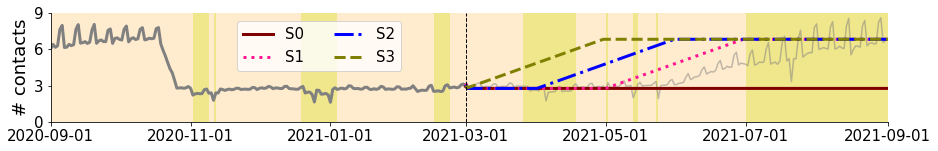

In [59]:
fig, ax = plt.subplots(figsize=(15,2))

# Background
week_color='blanchedalmond'#'white'
weekend_color='blanchedalmond'#'lightgrey'
vacation_color='khaki'#weekend_color
color_timeframes(start_date, end_date, ax=ax, week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

# Social interaction time series
linewidth=3
cutoff_index = np.where(np.array(days)>scenario_start)[0][0]
color_actual = 'grey'
ax.plot(days[:cutoff_index], np.array(behaviours_actual[:cutoff_index]), linewidth=linewidth, color=color_actual)
ax.plot(days[cutoff_index-1:], np.array(behaviours_actual[cutoff_index-1:]), linewidth=linewidth/2, color=color_actual, alpha=0.5)
ax.plot(days[cutoff_index-1:], np.array(behaviours_S0[cutoff_index-1:]), linewidth=linewidth, label='S0', color=color_S0, linestyle=linestyle_S0)
ax.plot(days[cutoff_index-1:], np.array(behaviours_S3[cutoff_index-1:]), linewidth=linewidth, label='S1', color=color_S3, linestyle=linestyle_S3)
ax.plot(days[cutoff_index-1:], np.array(behaviours_S2[cutoff_index-1:]), linewidth=linewidth, label='S2', color=color_S2, linestyle=linestyle_S2)
ax.plot(days[cutoff_index-1:], np.array(behaviours_S1[cutoff_index-1:]), linewidth=linewidth, label='S3', color=color_S1, linestyle=linestyle_S1)
ax.grid(False)
ax.set_xlim(pd.Timestamp(2020, 9, 1), pd.Timestamp(2021, 9, 1))
ax.set_ylim([0, 8])
ax.set_yticks([0, 3, 6, 9], size=14)
ax.axvline(scenario_start, linestyle='--', color='k', linewidth=1)
ax.set_ylabel('# contacts', fontsize=18)

xticks=[pd.Timestamp(2020, 9, 1).date(), pd.Timestamp(2020, 11, 1).date(), pd.Timestamp(2021, 1, 1).date(), \
               pd.Timestamp(2021, 3, 1).date(), pd.Timestamp(2021, 5, 1).date(), pd.Timestamp(2021, 7, 1).date(), \
               pd.Timestamp(2021, 9, 1).date()]
ax.set_xticks(xticks, size=14)

ax.legend(bbox_to_anchor=(0.32, 0.4), ncol=2)

# plt.savefig("four_projected_Nc_1mar2021.pdf", dpi=800, bbox_inches='tight')

# Visualising the social contact (extra)

In [ ]:
# ALL SOCIAL CONTACT (in home province)

# l1 = model_S1.parameters['l1']
# l2 = model_S1.parameters['l2']
# eff_schools = np.median(samples_dict['eff_schools'])
# eff_work = np.median(samples_dict['eff_work'])
# eff_rest = np.median(samples_dict['eff_rest'])
# eff_home = np.median(samples_dict['eff_home'])
# mentality = np.median(samples_dict['mentality'])

# days = []
# behaviours_actual = []
# behaviours_S0 = []
# behaviours_S1 = []
# behaviours_S2 = []
# behaviours_S3 = []

# for d in range(400):
#     print(f"Working on day {d}.", end='\r')
#     day = pd.Timestamp(2020, 8, 1) + pd.Timedelta(days=d)
#     days.append(day)
#     behaviour_actual = np.mean(np.sum(policy_function_actual(day, 0, 0, l1, l2, eff_schools, eff_work, eff_rest, eff_home, mentality)[0], axis=0))
#     behaviour_S0 = np.mean(np.sum(policy_function(day, 0, 0, l1, l2, eff_schools, eff_work, eff_rest, eff_home, mentality, 'S0')[0], axis=0))
#     behaviour_S1 = np.mean(np.sum(policy_function(day, 0, 0, l1, l2, eff_schools, eff_work, eff_rest, eff_home, mentality, 'S1')[0], axis=0))
#     behaviour_S2 = np.mean(np.sum(policy_function(day, 0, 0, l1, l2, eff_schools, eff_work, eff_rest, eff_home, mentality, 'S2')[0], axis=0))
#     behaviour_S3 = np.mean(np.sum(policy_function(day, 0, 0, l1, l2, eff_schools, eff_work, eff_rest, eff_home, mentality, 'S3')[0], axis=0))
#     behaviours_actual.append(behaviour_actual)
#     behaviours_S0.append(behaviour_S0)
#     behaviours_S1.append(behaviour_S1)
#     behaviours_S2.append(behaviour_S2)
#     behaviours_S3.append(behaviour_S3)

fig, ax = plt.subplots(figsize=(15,3))

# Background
week_color='blanchedalmond'#'white'
weekend_color='blanchedalmond'#'lightgrey'
vacation_color='khaki'#weekend_color
color_timeframes(start_date, end_date, ax=ax, week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

# Social interaction time series
linewidth=2
cutoff_index = np.where(np.array(days)>pd.Timestamp(2021, 2, 23))[0][0]
color_actual = 'orange'
ax.plot(days[:cutoff_index], behaviours_actual[:cutoff_index], linewidth=linewidth, color=color_actual)
ax.plot(days[cutoff_index:], behaviours_actual[cutoff_index:], linewidth=linewidth, color=color_actual, alpha=0.5)
ax.plot(days[cutoff_index:], behaviours_S0[cutoff_index:], linewidth=linewidth, label='S0', color=color_S0)
ax.plot(days[cutoff_index:], behaviours_S1[cutoff_index:], linewidth=linewidth, label='S1', color=color_S1)
ax.plot(days[cutoff_index:], behaviours_S2[cutoff_index:], linewidth=linewidth, label='S2', color=color_S2)
ax.plot(days[cutoff_index:], behaviours_S3[cutoff_index:], linewidth=linewidth, label='S3', color=color_S3)

ax.axvline(pd.Timestamp(2021, 2, 23), linestyle='--', color='k', linewidth=1)

ax.grid(False)
ax.set_xlim([pd.Timestamp(2020, 9, 1), pd.Timestamp(2021, 7, 1)])
ax.legend(ncol=2, bbox_to_anchor=(0.3, 0.5))

# Formatting
xticks=[pd.Timestamp(2020, 9, 1).date(), pd.Timestamp(2020, 11, 1).date(), pd.Timestamp(2021, 1, 1).date(), \
               pd.Timestamp(2021, 3, 1).date(), pd.Timestamp(2021, 5, 1).date(), pd.Timestamp(2021, 7, 1).date()]
ticklabelsize=14
ax.set_xticks(ticks=xticks, rotation=0, size=ticklabelsize, ha='center')
ax.set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')
ax.set_xlabel(None)
ax.set_ylabel('Avg. daily interactions')

In [ ]:
# WORK SOCIAL CONTACT (in visited province)

eff_work = np.median(samples_dict['eff_work'])
mentality = np.median(samples_dict['mentality'])

days_work = []
behaviours_actual_work = []
behaviours_S0_work = []
behaviours_S1_work = []
behaviours_S2_work = []
behaviours_S3_work = []

for d in range(400):
    print(f"Working on day {d}.", end='\r')
    day_work = pd.Timestamp(2020, 8, 1) + pd.Timedelta(days=d)
    days_work.append(day_work)
    behaviour_actual_work = np.mean(np.sum(policy_function_work_actual(day_work, 0, 0, eff_work, mentality)[0], axis=0))
    behaviour_S0_work = np.mean(np.sum(policy_function_work(day_work, 0, 0, eff_work, mentality, 'S0')[0], axis=0))
    behaviour_S1_work = np.mean(np.sum(policy_function_work(day_work, 0, 0, eff_work, mentality, 'S1')[0], axis=0))
    behaviour_S2_work = np.mean(np.sum(policy_function_work(day_work, 0, 0, eff_work, mentality, 'S2')[0], axis=0))
    behaviour_S3_work = np.mean(np.sum(policy_function_work(day_work, 0, 0, eff_work, mentality, 'S3')[0], axis=0))
    behaviours_actual_work.append(behaviour_actual_work)
    behaviours_S0_work.append(behaviour_S0_work)
    behaviours_S1_work.append(behaviour_S1_work)
    behaviours_S2_work.append(behaviour_S2_work)
    behaviours_S3_work.append(behaviour_S3_work)

fig, ax = plt.subplots(figsize=(15,3))
linewidth=2
cutoff_index_work = np.where(np.array(days_work)>pd.Timestamp(2021, 2, 23))[0][0]
color_actual_work = 'orange'
ax.plot(days_work[:cutoff_index_work], behaviours_actual_work[:cutoff_index], linewidth=linewidth, color=color_actual_work)
ax.plot(days_work[cutoff_index:], behaviours_actual_work[cutoff_index_work:], linewidth=linewidth, color=color_actual_work, alpha=0.5)
ax.plot(days_work[cutoff_index_work:], behaviours_S0_work[cutoff_index_work:], linewidth=linewidth, label='S0', color=color_S0)
ax.plot(days_work[cutoff_index_work:], behaviours_S1_work[cutoff_index_work:], linewidth=linewidth, label='S1', color=color_S1)
ax.plot(days_work[cutoff_index_work:], behaviours_S2_work[cutoff_index_work:], linewidth=linewidth, label='S2', color=color_S2)
ax.plot(days_work[cutoff_index_work:], behaviours_S3_work[cutoff_index_work:], linewidth=linewidth, label='S3', color=color_S3)

plt.axvline(pd.Timestamp(2021, 2, 23), linestyle='--', color='k', linewidth=1)

ax.grid(False)
ax.set_xlim([pd.Timestamp(2020, 9, 1), pd.Timestamp(2021, 7, 1)])
ax.legend(bbox_to_anchor=(0.14, 0.8), ncol=4)

In [ ]:
(pd.Timestamp(2021, 1, 30) - pd.Timestamp(2021, 1, 20)).days